# <h1 align=center> **EDA | SISTEMA DE RECOMENDACIÓN (ML-Model)**</h1>

**Para el diseño y modelado del sistema de recomendación se utilizará un enfoque de filtro basado en contenido.**

Para esto se realizará un análisis **`items-items`** y se buscará inferir las recomendaciones a partir de similitudes entre ítems aplicando la técnica similitud coseno.

Gracias al proceso de ETL y EDA realizado previamente, podemos saber qué datos tenemos a disposición para este enfoque. Y los datos que mejor se adaptan los contiene el dataset que precisamente contiene información relacionada a los juegos: **`steam_games`**

A continuación procedemos a realizar un EDA enfocado en este dataframe que deriva de la etapa anterior: *df_games*

# EDA df_games

El objetivo en esta etapa es reconocer la información más relevante para nuestro modelo de recomendación, por lo cual trataremos de identidicar rapidamente estos campos y avanzaremos en un análisis más exhaustivo sobre ellos

In [2]:
# importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
# Leemos el archivo df_games.csv creado en la etapa de ETL
df_games = pd.read_csv('df_games.csv')
df_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,4.49,['Single-player'],4.99,0.0,761140.0,NaN,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,NaN,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,NaN,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,NaN,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290.0,NaN,Poolians.com


Necesitamos contar con datos identificatorios como el id del juego y el nombre, por lo cual sabemos que los campos "id" y "title" los vamos a ocupar. Veamos entonces con que atributos nos conviene quedarnos para evaluar las similitudes entre los juegos

In [19]:
#revisamos la info general
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24064 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  float64
 12  id              32133 non-null  float64
 13  metascore       2607 non-null   float64
 14  developer       28836 non-null  object 
dtypes: float64(4), object(11)
memory usage: 3.7+ MB


Podemos observar que en principio contamos con 32133 juegos (cantidad de id's) 

Observamos tambien, que contamos con 2 campos que a priori parecen contar con buena información para nuestro modelo, estos son: genres y tags 

In [20]:
df_games = df_games[['id','title','tags','genres']]
df_games

,id,title,tags,genres
0,761140.0,Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...","['Action', 'Casual', 'Indie', 'Simulation', 'S..."
1,643980.0,Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Free to Play', 'Indie', 'RPG', 'Strategy']"
2,670290.0,Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Casual', 'Free to Play', 'Indie', 'Simulatio..."
3,767400.0,弹炸人2222,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']"
4,773570.0,NaN,"['Action', 'Indie', 'Casual', 'Sports']",NaN
...,...,...,...,...
32130,773640.0,Colony On Mars,"['Strategy', 'Indie', 'Casual', 'Simulation']","['Casual', 'Indie', 'Simulation', 'Strategy']"
32131,733530.0,LOGistICAL: South Africa,"['Strategy', 'Indie', 'Casual']","['Casual', 'Indie', 'Strategy']"
32132,610660.0,Russian Roads,"['Indie', 'Simulation', 'Racing']","['Indie', 'Racing', 'Simulation']"
32133,658870.0,EXIT 2 - Directions,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","['Casual', 'Indie']"


In [21]:
# Analizamos valores nulos
df_games.isnull().sum()

id           2
title     2050
tags       163
genres    3283
dtype: int64

In [22]:
df_games[df_games.id.isnull()]

,id,title,tags,genres
74,NaN,NaN,NaN,NaN
30961,NaN,Batman: Arkham City - Game of the Year Edition,"['Action', 'Open World', 'Batman', 'Adventure'...","['Action', 'Adventure']"


Vemos con un registro nulo en id contiene el resto de la informacion, sin embargo consultando en el resto de los dataset no se encotro la informacion del id, se eliminan ambos. 

Oservando los valores nulos en cada campo vemos que no contamos con la cantidad total de los nombres de los juegos, valores que necesitamos para el modelo, lo cual debemos quitar esos registros. Por otra parte en generos contamos con mas faltantes aun que en titulos, lo cual nos haria quedar con menos juegos que los que tenemos y no seria una buena decision en principio

In [23]:
# eliminamos nulos de 'title'
df_games.dropna(subset=['id','title'], inplace=True)
df_games.reset_index(drop=True,inplace=True)

In [24]:
df_games.isnull().sum()

id           0
title        0
tags       161
genres    1234
dtype: int64

In [25]:
df_games.id = df_games.id.astype(int) #pasamos los valores de id de float a int

Analizamos estos campos

In [29]:
print('valor tag:', df_games.tags[0], 'tipo de dato:',type(df_games.tags[0]))
print('valor genre:', df_games.genres[0], 'tipo de dato:',type(df_games.genres[0]))

valor tag: ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'] tipo de dato: <class 'str'>
valor genre: ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] tipo de dato: <class 'str'>


Tenemos generos y tags con valores similares. Analizamos con cual nos quedamos para avanzar con el modelo.

In [31]:
#Contamos cuantos valores similares hay entre ambos
conteo = df_games['genres'].eq(df_games['tags']).value_counts()
conteo

False    22438
True      7646
Name: count, dtype: int64

Hay una considerable similitud entre los campos, parece adecuado quedarse con uno solo de ellos. Analicemos ambos campos de manera mas comparativa, para esto resulta adecuado crear un dataframe con solo estos dos campos

In [38]:
df_comparativo = df_games[['tags','genres']]
df_comparativo

,tags,genres
0,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...","['Action', 'Casual', 'Indie', 'Simulation', 'S..."
1,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Free to Play', 'Indie', 'RPG', 'Strategy']"
2,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Casual', 'Free to Play', 'Indie', 'Simulatio..."
3,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']"
4,"['Action', 'Adventure', 'Simulation', 'FPS', '...","['Action', 'Adventure', 'Simulation']"
...,...,...
30079,"['Action', 'Indie', 'Casual', 'Violent', 'Adve...","['Action', 'Adventure', 'Casual', 'Indie']"
30080,"['Strategy', 'Indie', 'Casual', 'Simulation']","['Casual', 'Indie', 'Simulation', 'Strategy']"
30081,"['Strategy', 'Indie', 'Casual']","['Casual', 'Indie', 'Strategy']"
30082,"['Indie', 'Simulation', 'Racing']","['Indie', 'Racing', 'Simulation']"


In [39]:
df_comparativo.dropna(inplace=True)

C:\Users\LENOVO IDEAPAD\AppData\Local\Temp\ipykernel_5556\4226371087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo.dropna(inplace=True)


Corregimos el tipo de dato de ambos ya que si bien parecen listas son strings, para esto utilizamos la libreria 'ast'

In [40]:
# Convertimos las cadenas de lista a listas reales
df_comparativo['tags'] = df_comparativo['tags'].apply(lambda x: ast.literal_eval(x))
df_comparativo['genres'] = df_comparativo['genres'].apply(lambda x: ast.literal_eval(x))

C:\Users\LENOVO IDEAPAD\AppData\Local\Temp\ipykernel_5556\445451866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo['tags'] = df_comparativo['tags'].apply(lambda x: ast.literal_eval(x))
C:\Users\LENOVO IDEAPAD\AppData\Local\Temp\ipykernel_5556\445451866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo['genres'] = df_comparativo['genres'].apply(lambda x: ast.literal_eval(x))


Veamos un poco la informacion de forma grafica

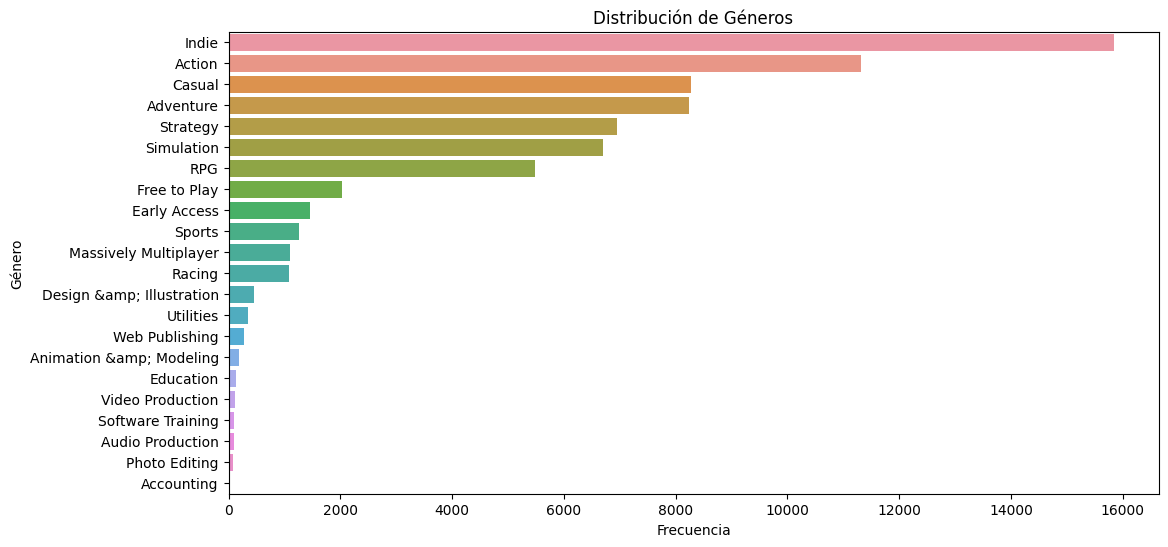

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contar la frecuencia de cada género
genre_counts = df_comparativo['genres'].explode().value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h')
plt.xlabel('Frecuencia')
plt.ylabel('Género')
plt.title('Distribución de Géneros')
plt.show()


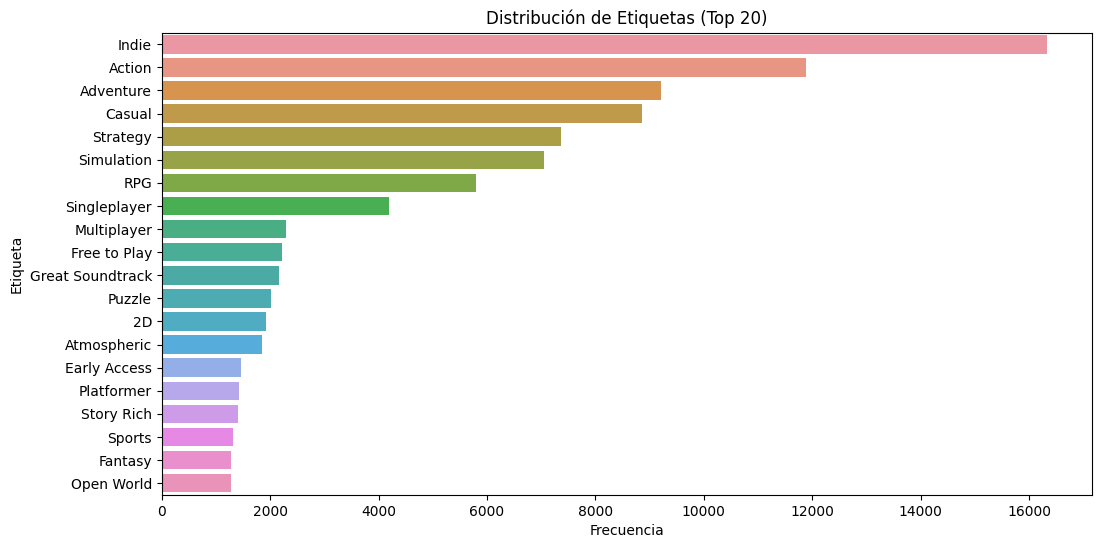

In [42]:
tag_counts = df_comparativo['tags'].explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.values[:20], y=tag_counts.index[:20], orient='h')
plt.xlabel('Frecuencia')
plt.ylabel('Etiqueta')
plt.title('Distribución de Etiquetas (Top 20)')
plt.show()


Se puede observar que si bien hay muchos atributos en comun entre ambos, 'tags' contiene muchos mas, lo que nos aporta mayor capacidad de comparacion entre items, para luego encontrar similitudes.

Veamos un ultimo grafico para comparar cantidad de atributos

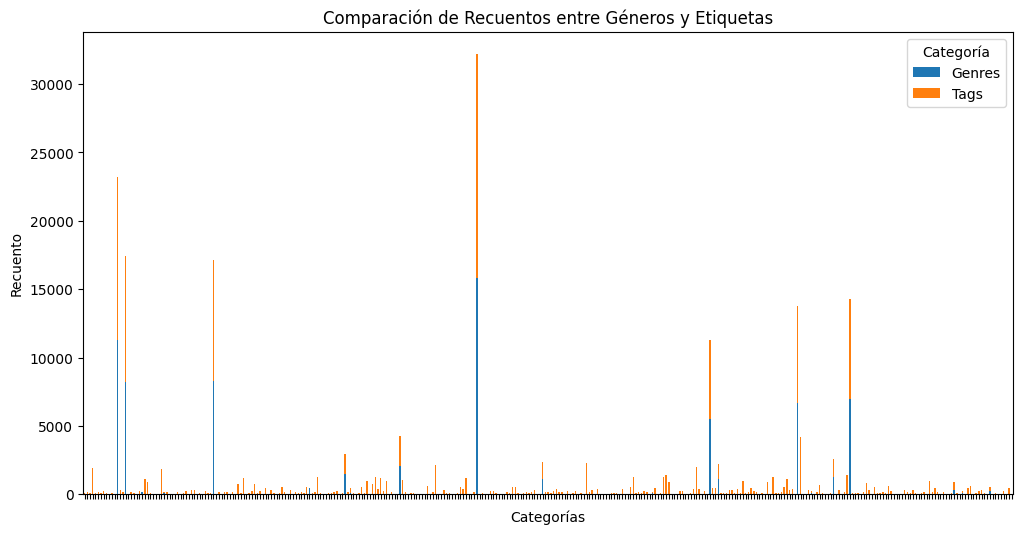

In [48]:
import matplotlib.pyplot as plt
# Supongamos que tienes un DataFrame df que contiene las columnas 'genres' y 'tags'

# Calcular la frecuencia de cada género en 'genres'
genre_counts = df_comparativo['genres'].explode().value_counts()

# Calcular la frecuencia de cada etiqueta en 'tags'
tag_counts = df_comparativo['tags'].explode().value_counts()

# Crear un nuevo DataFrame con los recuentos
data = {'Genres': genre_counts, 'Tags': tag_counts}
df_counts = pd.DataFrame(data)

# Graficar los recuentos en un gráfico de barras apiladas
ax = df_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_xticklabels([])
plt.xlabel('Categorías')
plt.ylabel('Recuento')
plt.title('Comparación de Recuentos entre Géneros y Etiquetas')
plt.legend(title='Categoría')

plt.show()


No es una visualizacion adecuada pero refuerza la idea de que es tags quien nos aporta mayor y mejor informacion.

En todas las comparaciones observamos que 'tags' contiene ademas de los generos otras etiquetas representativas del juego, por lo cual aporta mayor informacion de interes que 'genres'. 
Ademas, se observa que tags es la que mas registro posee, es decir la que mas juegos abarca de las 2.

**En conclusión, seguimos el análisis utilizando sólo la columna de **`tags`** para evaluar las similitudes entre los juegos.**

Volviendo a nuestro dataframe

In [52]:
# eliminamos genres
del(df_games['genres'])

In [53]:
df_games.head(2)

,id,title,tags
0,761140,Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim..."
1,643980,Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '..."


In [54]:
#Eliminamos nulos restantes y corregimos tipo de dato
df_games.dropna(inplace=True)
df_games['tags'] = df_games['tags'].apply(lambda x: ast.literal_eval(x))

In [55]:
df_games

,id,title,tags
0,761140,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]"
1,643980,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game..."
2,670290,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind..."
3,767400,弹炸人2222,"[Action, Adventure, Casual]"
4,772540,Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter, ..."
...,...,...,...
30079,745400,Kebab it Up!,"[Action, Indie, Casual, Violent, Adventure]"
30080,773640,Colony On Mars,"[Strategy, Indie, Casual, Simulation]"
30081,733530,LOGistICAL: South Africa,"[Strategy, Indie, Casual]"
30082,610660,Russian Roads,"[Indie, Simulation, Racing]"


**Ahora sí, tenemos un dataframe listo para pasar al modelado**

---

# Modelado

En esta etapa se realizará el modelado con el objetivo de obtener la matriz de similitudes que utilizaremos en nuestra función luego en la API

En primer lugar desanidamos los valores dentro de tags para luego codificarlos

In [56]:
all_tags = df_games['tags'].explode().tolist()


In [57]:
# Calculamos la cantidad de tags unicas, a tener en cuenta a la hora de codificar
all_tags = df_games['tags'].explode().tolist()
print('cantidad de tags unicas:', len(list(set(all_tags))))

cantidad de tags unicas: 337


Codificación de los atributos en "tags" en valores "Dummies"

In [58]:
# Agregamos un índice temporal para no perderlo y luego reindexar originalmente
df_games['index'] = range(len(df_games))

# Codificamos los géneros en columnas one-hot
df_encoded = pd.get_dummies(df_games['tags'].explode())

# Combinamos los datos nuevamente utilizando groupby para eliminar filas duplicadas
df_dummies = df_games[['index']].join(df_encoded).groupby('index', as_index=False).max()

# Eliminamos el índice temporal
df_dummies.drop(columns=['index'], inplace=True)
df_games.drop(columns=['index'], inplace=True)

# df_dummies ahora contiene la codificación one-hot y mantiene el orden original

In [59]:
df_dummies.head(3)

,1980s,1990's,2.5D,2D,2D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


---

Finalmente concatenamos ambos df creados para obtener a partir de este la matriz de similitudes

In [60]:
df_final = pd.concat([df_games, df_dummies],axis = 1)
df_final

,id,title,tags,1980s,1990's,2.5D,2D,2D Fighter,3D Platformer,3D Vision,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,761140.0,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,643980.0,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,670290.0,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,767400.0,弹炸人2222,"[Action, Adventure, Casual]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,772540.0,Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter, ...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29595,NaN,NaN,NaN,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
29597,NaN,NaN,NaN,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29609,NaN,NaN,NaN,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29622,NaN,NaN,NaN,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
df_final[df_final.id == 10]

,id,title,tags,1980s,1990's,2.5D,2D,2D Fighter,3D Platformer,3D Vision,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
30056,10.0,Counter-Strike,"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### *Exportamos el df resultante para luego utilizarlo en el servidor*

In [53]:
df_final.to_parquet('df_final_games.parquet')

---

### Creamos la matriz de similitudes utilizando la libreria sklearn la cual utiliza la *similitud coseno*

In [ ]:
similitudes = cosine_similarity(df_final.iloc[:,3:])

In [13]:
similitudes

array([[1.        , 0.10259784, 0.18257419, ..., 0.25819889, 0.        ,
        0.        ],
       [0.10259784, 1.        , 0.09365858, ..., 0.        , 0.        ,
        0.        ],
       [0.18257419, 0.09365858, 1.        , ..., 0.        , 0.23570226,
        0.        ],
       ...,
       [0.25819889, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.23570226, ..., 0.        , 1.        ,
        0.23570226],
       [0.        , 0.        , 0.        , ..., 0.        , 0.23570226,
        1.        ]])

---

# Función de recomendación

Finalmente desarrollamos la función que nos retorne las recomendaciones a partir de un juego de interés

In [89]:
def recommend_games(game_id: int):
    '''
    Esta función recomienda 5 juegos a partir del juego ingresado.

    Args:
        game_id (int): ID único del videojuego al cual se le harán las recomendaciones.
    '''
    # Verifica si el juego con game_id existe en df_games
    game = df_final[df_final['id'] == game_id]

    if game.empty:
        raise HTTPException(status_code=404, detail=f"El juego '{game_id}' no posee registros.")
    
    # Obtiene el índice del juego dado
    idx = game.index[0]

    # Toma una muestra aleatoria del DataFrame df_games
    sample_size = 10000  # Define el tamaño de la muestra (ajusta según sea necesario)
    df_sample = df_final.sample(n=sample_size, random_state=42)  # Ajusta la semilla aleatoria según sea necesario

    # Calcula la similitud de contenido solo para el juego dado y la muestra
    sim_scores = cosine_similarity([df_final.iloc[idx, 3:]], df_sample.iloc[:, 3:])

    # Obtiene las puntuaciones de similitud del juego dado con otros juegos
    sim_scores = sim_scores[0]

    # Ordena los juegos por similitud en orden descendente
    similar_games = [(i, sim_scores[i]) for i in range(len(sim_scores)) if i != idx]
    similar_games = sorted(similar_games, key=lambda x: x[1], reverse=True)

    # Obtiene los 5 juegos más similares
    similar_game_indices = [i[0] for i in similar_games[:5]]

    # Lista de juegos similares (solo nombres)
    similar_game_names = df_sample['title'].iloc[similar_game_indices].tolist()

    return {"similar_games": similar_game_names}


### Corroboramos los resultados

In [98]:
recommend_games(10)

{'similar_games': ['Counter-Strike: Condition Zero',
  'Counter-Strike: Global Offensive',
  "Tom Clancy's Rainbow Six® Siege - Ultra HD Texture Pack",
  'Day of Defeat',
  'Quake Live™']}

In [21]:
df_games[df_games.id == 10]

,id,title,tags
29895,10,Counter-Strike,"[Action, FPS, Multiplayer, Shooter, Classic, T..."


In [91]:
df_games[df_games.title == 'Counter-Strike: Condition Zero']

,id,title,tags
29906,80,Counter-Strike: Condition Zero,"[Action, FPS, Shooter, Multiplayer, Singleplay..."


In [92]:
df_games[df_games.title ==  'Counter-Strike: Global Offensive']

,id,title,tags
1020,730,Counter-Strike: Global Offensive,"[FPS, Multiplayer, Shooter, Action, Team-Based..."


In [93]:
df_games[df_games.title ==  "Tom Clancy's Rainbow Six® Siege - Ultra HD Texture Pack"]

,id,title,tags
4902,377560,Tom Clancy's Rainbow Six® Siege - Ultra HD Tex...,"[Action, Multiplayer, FPS, First-Person, Shoot..."


In [96]:
df_games[df_games.title =='Day of Defeat']

,id,title,tags
29903,30,Day of Defeat,"[FPS, World War II, Multiplayer, Action, Shoot..."


In [95]:
df_games[df_games.title == 'Quake Live™']

,id,title,tags
26226,282440,Quake Live™,"[FPS, Multiplayer, Classic, Arena Shooter, Fas..."


---

# Conclusión

Se creó exitosamente el sistema de recomendación. Se pudo corroborar que los resultados que arroja la función son correctos y devuelve los items con mayor similitud de acuerdo a los atributos extraídos de la columna 'tags'.

La función busca ser lo mas óptima posible debido a las limitaciones de render. Sin embargo resulta imposible procesar la matriz de similitudes generada para todo el dataframe resultante, por lo tanto se toma la decisión de utilizar una muestra y no todo el dataframe. Esto se realiza dentro de la función, cada vez que se consulta se crea una muestra aleatoria del df_games_final con el fin de bajar el costo de procesamiento y que se pueda correr sin problemas en el servidor de render. 

---